In [7]:
import numpy as np
import pandas as pd
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, GlobalMaxPool1D
from sklearn.model_selection import train_test_split
import pickle

In [8]:
data = pd.read_csv('IMDB Dataset.csv')
data.head()

,review,sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


In [9]:
data.columns

Index(['review', 'sentiment'], dtype='object')

In [10]:
# Step 3: Extract text and labels
texts = data['review'].tolist()  # Reviews
labels = data['sentiment'].tolist()  # Sentiments ("positive" or "negative")

# Step 4: Initialize and fit a tokenizer
tokenizer = Tokenizer(num_words=5000, oov_token="<OOV>")
tokenizer.fit_on_texts(texts)

# Step 5: Save the tokenizer for future use
with open("tokenizer.pkl", "wb") as handle:
    pickle.dump(tokenizer, handle)
print("Tokenizer saved as tokenizer.pkl")

Tokenizer saved as tokenizer.pkl


In [11]:
def noiseremoval_text(text):
    soup = BeautifulSoup(text, 'html.parser')
    text = soup.get_text()
    text = re.sub(r'\[[^]]*\]', '', text)
    return text             

In [12]:
#Data Preprocessing: Encode labels and split data
data['sentiment'] = data['sentiment'].map({'positive': 1, 'negative': 0})  # Encode sentiments as binary
X = data['review'].values
y = data['sentiment'].values

In [13]:
# Split the data into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.2, random_state=42)

In [14]:
# 3.Tokenization and Padding
vocab_size = 10000
maxlen = 200

In [15]:
# Initialize the tokenizer and fit on the training data
tokenizer = Tokenizer(num_words=vocab_size, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

# Convert text to sequences and pad them
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=maxlen, padding='post')
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=maxlen, padding='post')

In [16]:
# Define the Model Architecture without `input_length`
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=128),  # Removed input_length
    LSTM(64, return_sequences=True),
    GlobalMaxPool1D(),
    Dense(64, activation='relu'),
    Dropout(0.5),
    Dense(1, activation='sigmoid')
])


from tensorflow.keras.callbacks import EarlyStopping
# Define the EarlyStopping callback
early_stopping = EarlyStopping(
    monitor='val_loss',  # Monitor validation loss
    patience=3,          # Number of epochs to wait for improvement
    restore_best_weights=True,  # Restore the weights of the best epoch
    verbose=1
)

In [17]:
# Compile the Model
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

In [18]:
# Train the model with early stopping
history = model.fit(
    X_train_seq, y_train,
    epochs=20,               # Set a higher number of epochs; training may stop early due to early stopping
    batch_size=32,
    validation_split=0.2,
    callbacks=[early_stopping]  # Pass the early stopping callback
)

Epoch 1/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 166s 160ms/step - accuracy: 0.7252 - loss: 0.5073 - val_accuracy: 0.8821 - val_loss: 0.2796
Epoch 2/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 202s 160ms/step - accuracy: 0.9216 - loss: 0.2112 - val_accuracy: 0.8808 - val_loss: 0.2792
Epoch 3/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 200s 158ms/step - accuracy: 0.9526 - loss: 0.1376 - val_accuracy: 0.8864 - val_loss: 0.2954
Epoch 4/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 161s 161ms/step - accuracy: 0.9757 - loss: 0.0768 - val_accuracy: 0.8851 - val_loss: 0.3732
Epoch 5/20
1000/1000 ━━━━━━━━━━━━━━━━━━━━ 200s 159ms/step - accuracy: 0.9857 - loss: 0.0475 - val_accuracy: 0.8802 - val_loss: 0.3773
Epoch 5: early stopping
Restoring model weights from the end of the best epoch: 2.


In [19]:
#Evaluate the Model on Test Data
loss, accuracy = model.evaluate(X_test_seq, y_test)
print(f"Test Accuracy: {accuracy * 100:.2f}%")

313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 50ms/step - accuracy: 0.8782 - loss: 0.2785
Test Accuracy: 88.13%


In [20]:
#Evaluate the Model on Test Data
loss, accuracy = model.evaluate(X_train_seq, y_train)
print(f"Train Accuracy: {accuracy * 100:.2f}%")

1250/1250 ━━━━━━━━━━━━━━━━━━━━ 66s 53ms/step - accuracy: 0.9451 - loss: 0.1569
Train Accuracy: 93.42%


You must install pydot (`pip install pydot`) for `plot_model` to work.
Model architecture saved as 'model_architecture.png'.


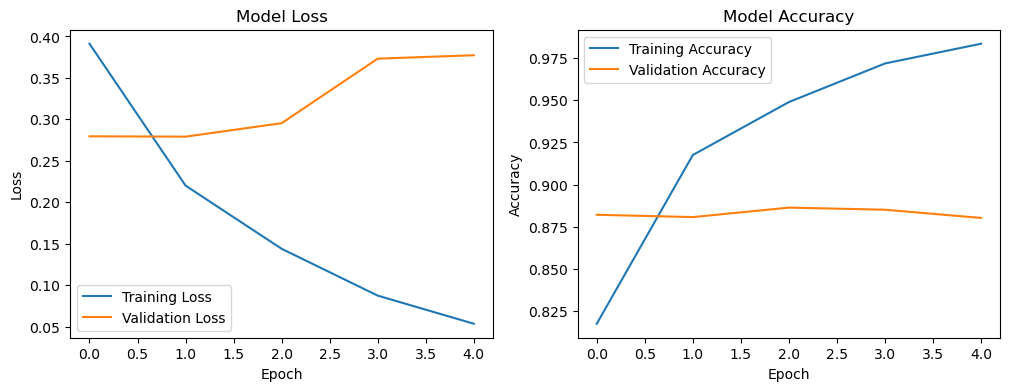

313/313 ━━━━━━━━━━━━━━━━━━━━ 17s 53ms/step


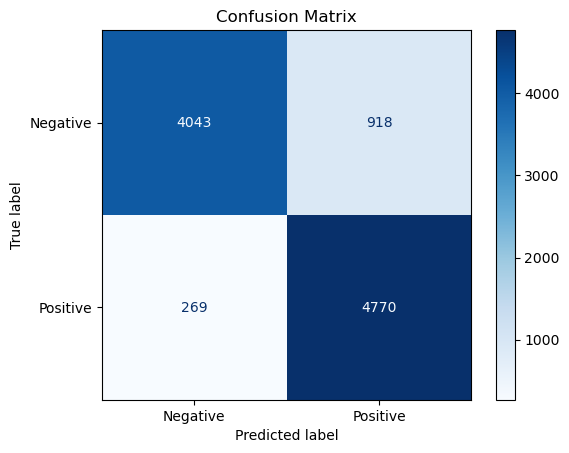

313/313 ━━━━━━━━━━━━━━━━━━━━ 16s 51ms/step


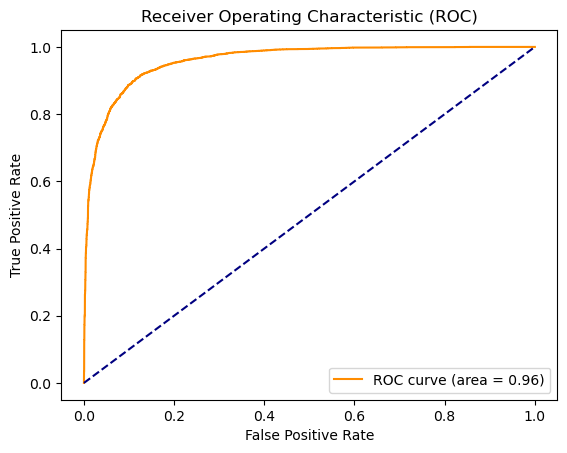

In [21]:
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay, roc_curve, auc
import numpy as np
from tensorflow.keras.utils import plot_model

# 1. Visualize Model Architecture
plot_model(model, to_file='model_architecture.png', show_shapes=True, show_layer_names=True)
print("Model architecture saved as 'model_architecture.png'.")

# 2. Visualize Training History (Accuracy and Loss)
def plot_training_history(history):
    # Plotting loss
    plt.figure(figsize=(12, 4))
    plt.subplot(1, 2, 1)
    plt.plot(history.history['loss'], label='Training Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.title('Model Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()

    # Plotting accuracy
    plt.subplot(1, 2, 2)
    plt.plot(history.history['accuracy'], label='Training Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.title('Model Accuracy')
    plt.xlabel('Epoch')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_training_history(history)

# 3. Confusion Matrix
# Generate predictions on the test set
y_pred = (model.predict(X_test_seq) > 0.5).astype("int32").flatten()
cm = confusion_matrix(y_test, y_pred)  # Replace `y_test` with your actual test labels

# Display the confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['Negative', 'Positive'])
disp.plot(cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.show()

# 4. ROC Curve
# Get probability predictions
y_prob = model.predict(X_test_seq).flatten()
fpr, tpr, _ = roc_curve(y_test, y_prob)  # Replace `y_test` with your actual test labels
roc_auc = auc(fpr, tpr)

# Plot the ROC curve
plt.figure()
plt.plot(fpr, tpr, color='darkorange', label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()

In [22]:
# Save the model
model.save('sentimentanlysis.h5')